In [1]:
stoi = {s:i for i, s in enumerate('.abcdefghijklmnopqrstuvwxyz')}
itos = {i: s for s, i in stoi.items()}


In [2]:
# Building Dataset
import torch
import torch.nn.functional as F
block_size = 3

with open('names.txt', 'r') as f:
    words = f.readlines()

X = []
Y = []

for word in words:
    context = [0] * block_size
    word = word.replace('\n', '')
    for char in word + '.':
        X.append(context)
        Y.append(stoi[char])
        # print(''.join([itos[i] for i in context]), '---->', itos[Y[-1]])
        context = context[1:] + [stoi[char]]
        

X = torch.tensor(X)        
Y = torch.tensor(Y)    
    

In [46]:
seed = 12345

n_embeds = 10
n_hidden = 200
vocab_size = 27

g = torch.Generator().manual_seed(seed)
C = torch.randn((27, n_embeds), generator=g, requires_grad=True)
embed = C[X]
W1 = torch.randn((n_embeds * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

# Selecting the good initialization for the model
- We want our logits to be as closer to zero as possible so all have equal probability

In [12]:

'''
With current initialization, we have random logits and a very high loss
'''
embs = C[X]
h = torch.tanh(embs.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())
print(logits[0])


15.588895797729492
tensor([ -1.4509,  30.9118,  -1.2465,   1.8099, -14.1369,   0.7008,   5.3383,
         12.7774,  24.2164,  10.0528, -13.9875,   6.4225,  -5.2979, -29.8048,
         -6.1790,   8.1128,  18.3900,  -1.4629,   9.7187,   1.1339,   5.7250,
        -23.6613,   7.6155,  -1.6565,   4.4218,   3.3672,  -9.3373],
       grad_fn=<SelectBackward0>)


'\nFor out init\n'

In [44]:
seed = 12345

n_embeds = 10
n_hidden = 200
vocab_size = 27

g = torch.Generator().manual_seed(seed)
C = torch.randn((27, n_embeds), generator=g, requires_grad=True)
embed = C[X]
W1 = torch.randn((n_embeds * block_size, n_hidden), generator=g, requires_grad=True)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # scaling down w so it is closer to 0
b2 = torch.randn(27, generator=g) * 0.01 # because we want logits to be zero so setting 0 to bias makes sense

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# can we set the weights to zero to acheive the same thing
- No we cannot 
- 

In [45]:
embs = C[X]
h = torch.tanh(embs.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())
print(logits[0])

3.301928997039795
tensor([ 0.2292, -0.1436, -0.0122,  0.0868, -0.1657,  0.3516,  0.0228, -0.0131,
        -0.0793,  0.0155,  0.0270, -0.0601,  0.1273,  0.1102, -0.0643,  0.1694,
        -0.1527, -0.1348,  0.1308, -0.0303,  0.1093, -0.3078, -0.1969, -0.1189,
        -0.0177, -0.0096, -0.1973], grad_fn=<SelectBackward0>)


- A better initialized network

# Selecting Learning Rate

In [43]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []


for i in range(1000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    embs = C[X[ix]]
    h = torch.tanh(embs.view(-1, n_embeds * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # make grads 0
    for p in parameters:
        p.grad = None

    loss.backward()
    lr = lrs[i]
    
    for p in parameters:
        print(type(p))
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())



RuntimeError: you can only change requires_grad flags of leaf variables.

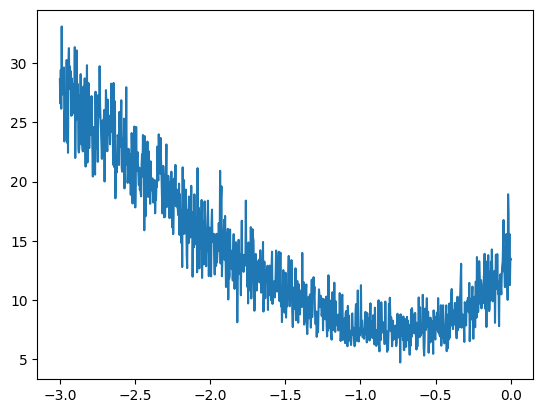

In [6]:
import matplotlib.pyplot as plt

# select learning rate from this plot
plt.plot(lri, lossi)


In [250]:
from tqdm import tqdm

lossi = []
stepsi = []

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        word = word.replace('\n', '')
        for char in word + '.':
            X.append(context)
            Y.append(stoi[char])
            # print(''.join([itos[i] for i in context]), '---->', itos[Y[-1]])
            context = context[1:] + [stoi[char]]
    X = torch.tensor(X)        
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

def train(Xtr, Ytr, batch_size=32, steps=10000, lr=0.1):
    lr_switch = steps//2
    for i in tqdm(range(steps)):
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        
        embs = C[Xtr[ix]]
        h = torch.tanh(embs.view(-1, n_embeds * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        for p in parameters:
            p.grad = None

        loss.backward()
        if i == lr_switch:
            lr = lr/10
        for p in parameters:
            p.data += -lr * p.grad
            
        # track stats
        stepsi.append(i)
        lossi.append(loss.item())
    plt.plot(stepsi, lossi)
    plt.show()     
    return

@torch.no_grad()
def test(Xte, Yte):
            
    embs = C[Xte]
    h = torch.tanh(embs.view(-1, n_embeds * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yte)
    
    for p in parameters:
        p.grad = None
    
    print(f"Loss: {loss.item()}")
    return
   

In [248]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


100%|██████████| 200000/200000 [01:41<00:00, 1979.81it/s]


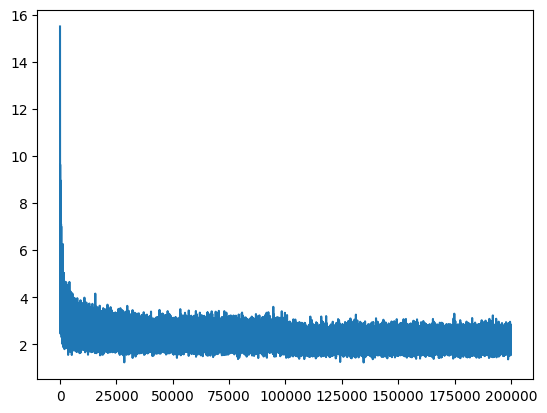

Loss: 2.171877145767212
Loss: 2.11287260055542


In [249]:
train(Xtr, Ytr, batch_size=32, steps=200_000, lr=0.1)
test(Xdev, Ydev)
test(Xtr, Ytr)

In [232]:
test(Xte, Yte)

Loss: 2.1881918907165527


In [255]:
def generate_name(start_chars='...', num_names=10):
    out = []
    for _ in range(num_names):
        name = start_chars
        row = name[-3:]
        
        while True:
            context = torch.tensor([stoi[char] for char in row])
            e = C[context]
            h = torch.tanh(e.view(-1, 30) @ W1 + b1)
            logits = h @ W2 + b2
            counts = logits.exp()
            probs = counts/ counts.sum(dim=1, keepdim=True)
            char = itos[torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()]
            name += char
            if char == '.':
                break
            row = name[-3:]
        out.append(name)
    return out

out = generate_name()
out      

['...amin.',
 '...yarajeison.',
 '...ola.',
 '...jerra.',
 '...meh.',
 '...sca.',
 '...micha.',
 '...mafel.',
 '...ezmi.',
 '...mawf.']